# Data

In [1]:
ydy_str = """0.06683	0.03261
0.07499	0.04072
0.08414	0.05035
0.0944	0.06201
0.10592	0.07605
0.11885	0.09151
0.13335	0.10952
0.14962	0.12881
0.16788	0.15028
0.18836	0.17177
0.21135	0.19233
0.23713	0.2121
0.26607	0.22905
0.29853	0.24251
0.33496	0.25466
0.37583	0.2646
0.42169	0.27705
0.47314	0.28203
0.53088	0.28568
0.59565	0.28799
0.66833	0.28923
0.74988	0.28742
0.84138	0.28077
0.94405	0.27784
1.05924	0.27432
1.18848	0.26549
1.3335	0.26059
1.49621	0.25302
1.67878	0.25053
1.88362	0.24313
2.11346	0.23783
2.37134	0.23015
2.66068	0.22429
2.98534	0.22064
3.3496	0.21484
3.75831	0.20871
4.2169	0.20343
4.73144	0.19903
5.30876	0.19129
5.95652	0.17558
6.68333	0.14832
7.49882	0.11457
8.41381	0.07635
9.44045	0.04301
10.59236	0.02064
11.88482	0.00897
13.33498	0.00371
14.9621	0.00141
16.78775	1.27E-04
18.83616	7.14E-05
"""

# Imports

In [2]:
from dataclasses import dataclass, field
from io import StringIO
from functools import lru_cache
from typing import List
import numpy as np
from scipy.integrate import quad
import pandas as pd
from tqdm.auto import tqdm

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

In [4]:
!python -V

Python 3.11.2


# Main dataclass

In [5]:
@dataclass
class Spectrum:
  bin_centers : List[float] = field(default_factory=list)
  bin_values_ydy : List[float] = field(default_factory=list)
  bin_values_yfy : List[float] = field(default_factory=list)

  @property
  def size(self) -> int:
    return self.bin_centers.size

  @property
  def bin_values_f(self):
    return self.bin_values_yfy / self.bin_centers

  @property
  def bin_centers_ratio(self) -> float:
    '''bin centers form a geometric serie'''
    first_bins = self.bin_centers[:-1]
    last_bins = self.bin_centers[1:]
    return (last_bins/first_bins).mean()

  @property
  def lowest_bin_left_edge(self) -> float:
    lowest_bin_center = self.bin_centers[0]
    return lowest_bin_center / self.bin_centers_ratio**0.5

  @property
  def bin_edges(self) -> List[float]:
    ''' e_n = e_0 * r^i for i=0...n'''
    e0 = self.lowest_bin_left_edge
    r = self.bin_centers_ratio
    exponents = np.arange(start=0, stop=self.size+1)
    return e0 * r**exponents

  @property
  def bin_widths_lin(self) -> List[float]:
    left_edges = self.bin_edges[:-1]
    right_edges = self.bin_edges[1:]
    return right_edges-left_edges

  @property
  def bin_widths_log10(self) -> List[float]:
    left_edges = np.log10(self.bin_edges[:-1])
    right_edges = np.log10(self.bin_edges[1:])
    return right_edges-left_edges

  def bin_no(self, y : float) -> int:
    '''
    solve y = e0 * r^x
    y / e0 = r^x
    ln(y/e0) = x * ln(r)
    '''
    e0 = self.lowest_bin_left_edge
    if y < 0:
      return -1
    real_exp = np.log(y/e0) / np.log(self.bin_centers_ratio)
    return np.floor(real_exp).astype(int)

  def bin_no_for_arrays(self, y : List[float]) -> List[int]:
    '''
    solve y = e0 * r^x
    y / e0 = r^x
    ln(y/e0) = x * ln(r)
    '''
    e0 = self.lowest_bin_left_edge
    real_exp = y.copy()
    real_exp[y>0] = np.log(y[y>0]/e0) / np.log(self.bin_centers_ratio)
    return np.floor(real_exp).astype(int)

  def bin_function(self, y : float, table: List[float]) -> float:
    ind = self.bin_no(y)
    if ind < 0:
      return 0.0
    if ind >= self.size:
      return 0.0
    return table[ind]

  def bin_function_ydy(self, y : float) -> float:
    return self.bin_function(y=y, table=self.bin_values_ydy)

  def bin_function_f(self, y : float) -> float:
    return self.bin_function(y=y, table=self.bin_values_f)

  def bin_function_for_arrays(self, y : float, table: List[float]) -> float:
    ind = self.bin_no_for_arrays(y)
    bin_values_extended = np.zeros(shape=(self.size+2,))
    bin_values_extended[1:-1] = table
    ind[ind < 0] = -1
    ind[ind >= self.size] = self.size
    return bin_values_extended.take(indices=ind+1, mode='clip')

  def bin_function_ydy_for_arrays(self, y : float) -> float:
    return self.bin_function_for_arrays(y=y, table=self.bin_values_ydy)

  @staticmethod
  def from_str(data: str):
    tmp_array = np.genfromtxt(StringIO(data))
    s = Spectrum()
    s.bin_centers = tmp_array[:,0]
    s.bin_values_ydy = tmp_array[:,1]
    s.bin_values_yfy = s.bin_values_ydy * 0.3617 / s.bin_centers
    return s

In [6]:
def integrand_for_convolution(t : float, y : float, data : Spectrum) -> float:
  return data.bin_function_f(t) * data.bin_function_f(y - t)

In [7]:
def integrand_for_norm(t : float, data : Spectrum) -> float:
  return data.bin_function_f(t)

# Preprocessing and inspection

In [8]:
data_ydy = np.genfromtxt(StringIO(ydy_str))

In [9]:
data = Spectrum.from_str(ydy_str)

## Plots

Text(0, 0.5, 'ydy')

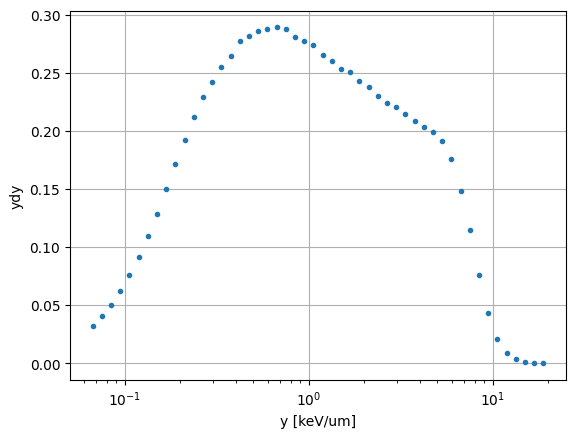

In [10]:
plt.plot(data.bin_centers, data.bin_values_ydy, '.')
plt.xscale('log')
plt.grid()
plt.xlabel('y [keV/um]')
plt.ylabel('ydy')

Text(0, 0.5, 'yfy')

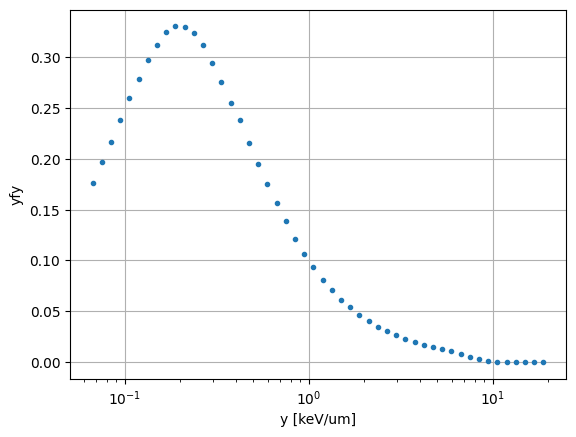

In [11]:
plt.plot(data.bin_centers, data.bin_values_yfy, '.')
plt.xscale('log')
plt.grid()
plt.xlabel('y [keV/um]')
plt.ylabel('yfy')

## Bins check

In [12]:
data.bin_centers_ratio

1.122019556979424

In [13]:
data.lowest_bin_left_edge

0.0630915573601932

In [14]:
data.bin_edges

array([ 0.06309156,  0.07078996,  0.07942772,  0.08911946,  0.09999377,
        0.11219497,  0.12588495,  0.14124537,  0.15848007,  0.17781774,
        0.19951498,  0.22385971,  0.25117498,  0.28182324,  0.31621118,
        0.35479513,  0.39808707,  0.44666148,  0.50116292,  0.5623146 ,
        0.63092797,  0.70791353,  0.79429282,  0.89121208,  0.99995738,
        1.12197174,  1.25887423,  1.41248151,  1.58483188,  1.77821236,
        1.99518905,  2.23864113,  2.51179913,  2.81828775,  3.16217397,
        3.54802104,  3.98094899,  4.46670262,  5.0117277 ,  5.62325649,
        6.30940376,  7.07927441,  7.94308434,  8.91229597,  9.99977037,
       11.21993792, 12.58898978, 14.12509273, 15.84863029, 17.78247314,
       19.95228263])

In [15]:
data.bin_centers

array([ 0.06683,  0.07499,  0.08414,  0.0944 ,  0.10592,  0.11885,
        0.13335,  0.14962,  0.16788,  0.18836,  0.21135,  0.23713,
        0.26607,  0.29853,  0.33496,  0.37583,  0.42169,  0.47314,
        0.53088,  0.59565,  0.66833,  0.74988,  0.84138,  0.94405,
        1.05924,  1.18848,  1.3335 ,  1.49621,  1.67878,  1.88362,
        2.11346,  2.37134,  2.66068,  2.98534,  3.3496 ,  3.75831,
        4.2169 ,  4.73144,  5.30876,  5.95652,  6.68333,  7.49882,
        8.41381,  9.44045, 10.59236, 11.88482, 13.33498, 14.9621 ,
       16.78775, 18.83616])

In [16]:
data.bin_widths_lin

array([0.0076984 , 0.00863776, 0.00969174, 0.01087432, 0.0122012 ,
       0.01368998, 0.01536043, 0.0172347 , 0.01933767, 0.02169724,
       0.02434473, 0.02731526, 0.03064826, 0.03438795, 0.03858395,
       0.04329194, 0.04857441, 0.05450144, 0.06115168, 0.06861338,
       0.07698555, 0.08637929, 0.09691926, 0.1087453 , 0.12201436,
       0.13690249, 0.15360728, 0.17235037, 0.19338048, 0.21697668,
       0.24345208, 0.273158  , 0.30648862, 0.34388622, 0.38584707,
       0.43292795, 0.48575363, 0.54502508, 0.61152879, 0.68614727,
       0.76987065, 0.86380993, 0.96921163, 1.08747441, 1.22016755,
       1.36905185, 1.53610296, 1.72353756, 1.93384285, 2.16980949])

In [17]:
data.bin_widths_log10

array([0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043,
       0.05000043, 0.05000043, 0.05000043, 0.05000043, 0.05000043])

In [18]:
# bins per decade
1. / data.bin_widths_log10.mean()

19.999829278239954

## histogram function

In [19]:
data.bin_no(y=data.lowest_bin_left_edge)

0

In [20]:
data.bin_no_for_arrays(y=data.bin_centers)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [21]:
data.bin_no_for_arrays(y=data.bin_edges)

array([ 0,  1,  2,  3,  3,  5,  6,  7,  7,  9, 10, 10, 11, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 21, 23, 23, 25, 26, 27, 28, 29, 30, 30, 32, 33,
       34, 35, 36, 36, 38, 39, 40, 40, 42, 43, 43, 45, 46, 47, 47, 49, 50])

In [22]:
data.bin_function_ydy(y=data.lowest_bin_left_edge), data.bin_values_ydy[0]

(0.03261, 0.03261)

In [23]:
data.bin_function_ydy(y=data.bin_centers[0]), data.bin_values_ydy[0]

(0.03261, 0.03261)

In [24]:
data.bin_function_ydy(y=data.bin_centers[-1]), data.bin_values_ydy[-1]

(7.14e-05, 7.14e-05)

In [25]:
data.bin_function_ydy(y=data.bin_edges[-1]), data.bin_values_ydy[-1]

(0.0, 7.14e-05)

In [26]:
data.bin_function_ydy_for_arrays(y=data.bin_centers)

array([3.2610e-02, 4.0720e-02, 5.0350e-02, 6.2010e-02, 7.6050e-02,
       9.1510e-02, 1.0952e-01, 1.2881e-01, 1.5028e-01, 1.7177e-01,
       1.9233e-01, 2.1210e-01, 2.2905e-01, 2.4251e-01, 2.5466e-01,
       2.6460e-01, 2.7705e-01, 2.8203e-01, 2.8568e-01, 2.8799e-01,
       2.8923e-01, 2.8742e-01, 2.8077e-01, 2.7784e-01, 2.7432e-01,
       2.6549e-01, 2.6059e-01, 2.5302e-01, 2.5053e-01, 2.4313e-01,
       2.3783e-01, 2.3015e-01, 2.2429e-01, 2.2064e-01, 2.1484e-01,
       2.0871e-01, 2.0343e-01, 1.9903e-01, 1.9129e-01, 1.7558e-01,
       1.4832e-01, 1.1457e-01, 7.6350e-02, 4.3010e-02, 2.0640e-02,
       8.9700e-03, 3.7100e-03, 1.4100e-03, 1.2700e-04, 7.1400e-05])

In [27]:
data.bin_function_ydy_for_arrays(y=data.bin_edges)

array([3.2610e-02, 4.0720e-02, 5.0350e-02, 6.2010e-02, 6.2010e-02,
       9.1510e-02, 1.0952e-01, 1.2881e-01, 1.2881e-01, 1.7177e-01,
       1.9233e-01, 1.9233e-01, 2.1210e-01, 2.4251e-01, 2.5466e-01,
       2.6460e-01, 2.7705e-01, 2.8203e-01, 2.8568e-01, 2.8799e-01,
       2.8923e-01, 2.8742e-01, 2.8742e-01, 2.7784e-01, 2.7784e-01,
       2.6549e-01, 2.6059e-01, 2.5302e-01, 2.5053e-01, 2.4313e-01,
       2.3783e-01, 2.3783e-01, 2.2429e-01, 2.2064e-01, 2.1484e-01,
       2.0871e-01, 2.0343e-01, 2.0343e-01, 1.9129e-01, 1.7558e-01,
       1.4832e-01, 1.4832e-01, 7.6350e-02, 4.3010e-02, 4.3010e-02,
       8.9700e-03, 3.7100e-03, 1.4100e-03, 1.4100e-03, 7.1400e-05,
       0.0000e+00])

In [28]:
xvalues = np.geomspace(start=data.bin_edges[0]/10, stop=data.bin_edges[-1]*10, num=1000)
yvalues = data.bin_function_ydy_for_arrays(y=xvalues)

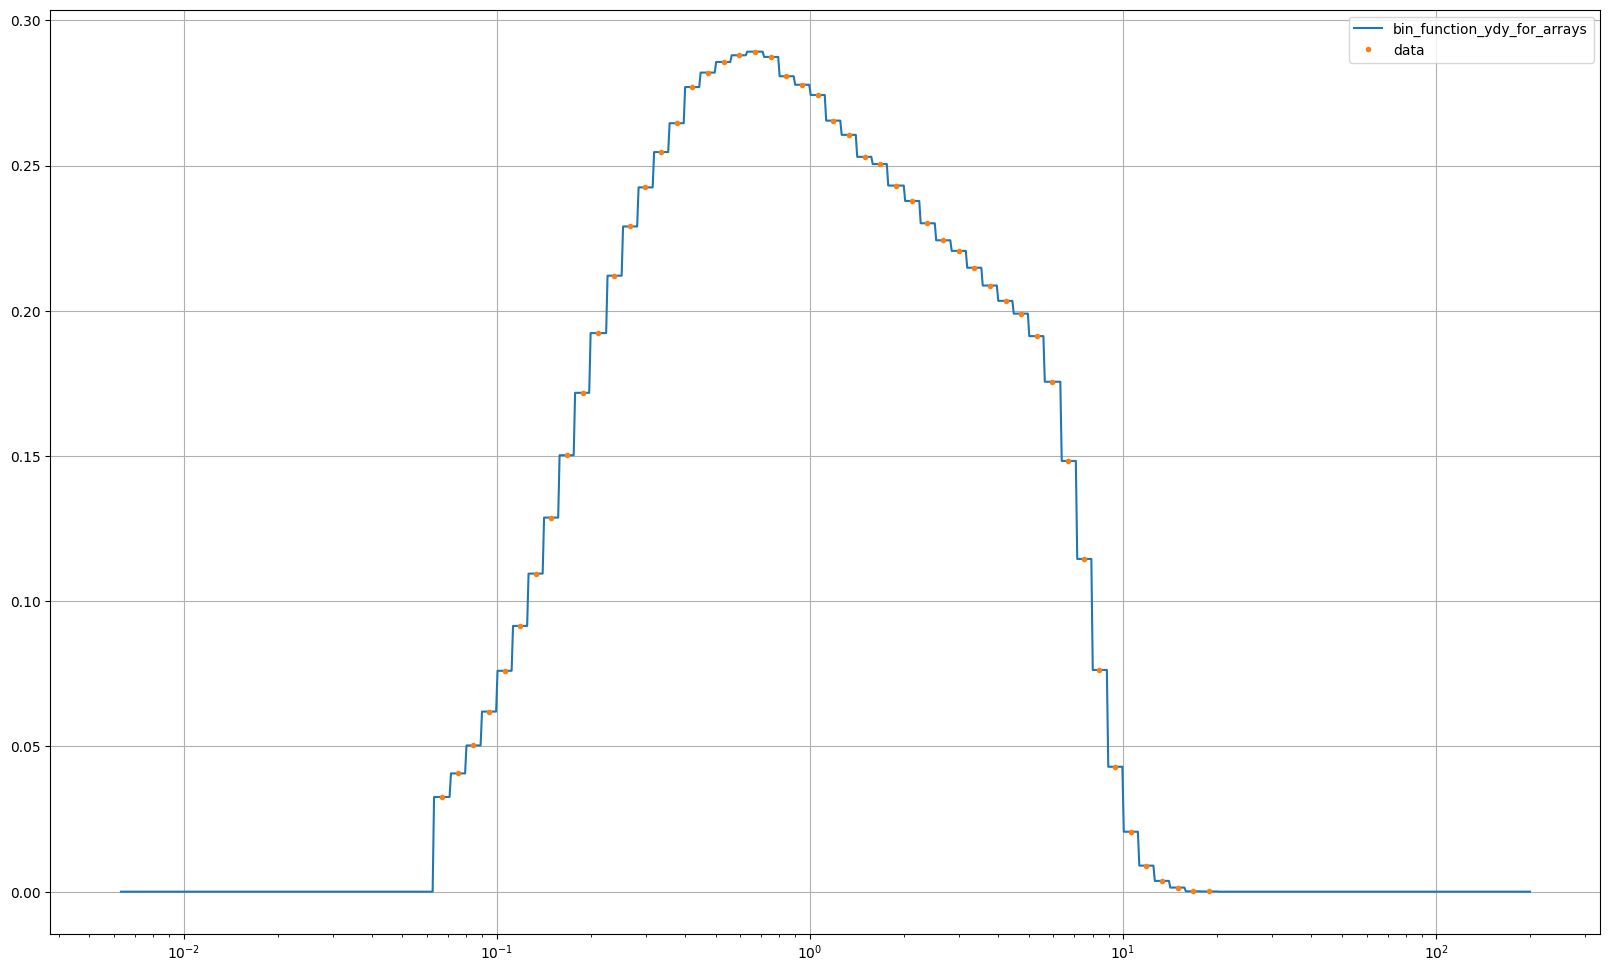

In [29]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(xvalues, yvalues, label="bin_function_ydy_for_arrays")
ax.plot(data.bin_centers, data.bin_values_ydy, '.', label='data')
ax.set_xscale('log')
ax.grid()
ax.legend()

## simple convolution test

In [30]:
def f_step(y : float) -> float:
  if y < 0:
    return 0
  if y > 2:
    return 0
  return 0.5*10

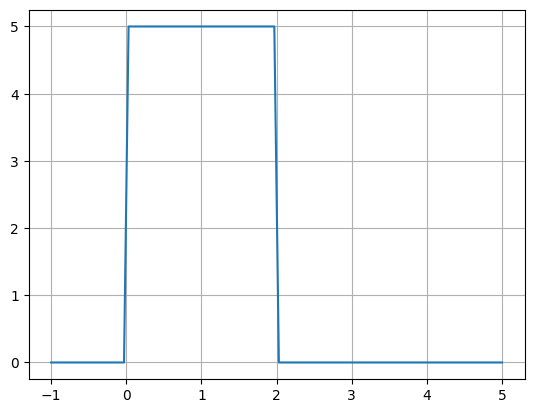

In [31]:
xvalues = np.linspace(start=-1, stop=5, num=100)
yvalues = [f_step(x) for x in xvalues]
fig, ax = plt.subplots()
ax.plot(xvalues, yvalues)
ax.grid();

In [32]:
def f_step_integrand(t: float, y : float) -> float:
  return f_step(t) * f_step(y-t)

In [33]:
def f2_step(y : float):
  try:
    low_limit = -2
    upp_limit = 4
    I = quad(f_step_integrand, low_limit, upp_limit, args=(y,), limit=1000)
  except RuntimeWarning:
    pass
  return I[0]

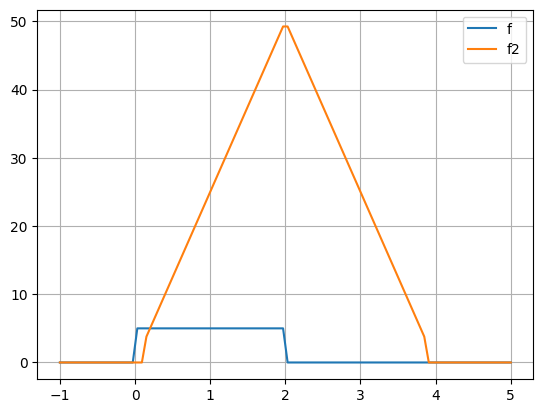

In [34]:
xvalues = np.linspace(start=-1, stop=5, num=100)
yvalues_f = [f_step(x) for x in xvalues]
yvalues_f2 = [f2_step(x) for x in xvalues]
fig, ax = plt.subplots()
ax.plot(xvalues, yvalues_f, label='f')
ax.plot(xvalues, yvalues_f2, label='f2')
ax.legend()
ax.grid();

## integrand

In [35]:
integrand_for_convolution(t=data.bin_edges[-1], y=data.bin_centers[10], data=data)

0.0

In [61]:
def f_norm(data: Spectrum) -> float:
  I = quad(integrand_for_norm, data.bin_edges[0], data.bin_edges[-1], args=(data,), limit=500, epsabs=1e-5, epsrel=1e-4)
  return I[0]

In [62]:
f_norm(data=data)

0.1854650909774389

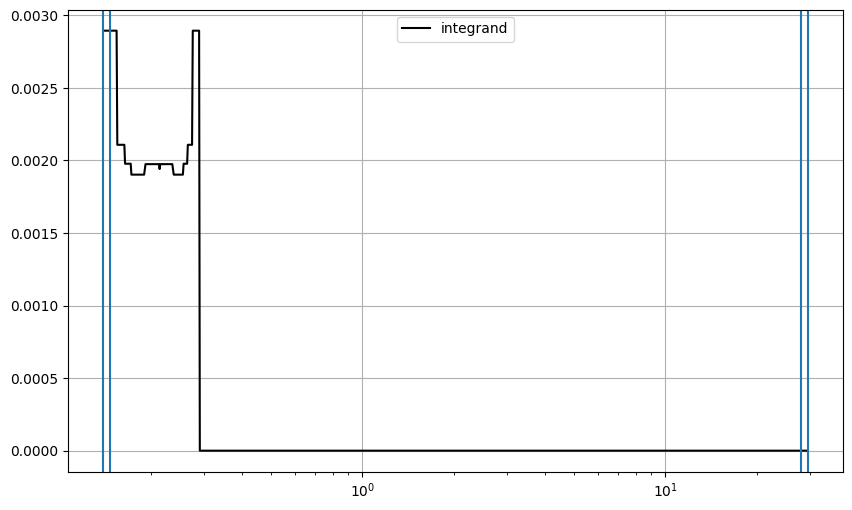

In [63]:
y0 = data.bin_centers[10]
xvalues = np.geomspace(start=data.bin_edges[0], stop=data.bin_edges[-1], num=1000)
yvalues = [integrand_for_convolution(t=x, y=y0, data=data) for x in xvalues]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(xvalues, yvalues, color='black', label='integrand')
ax.axvline(x=data.bin_edges[0])
ax.axvline(x=data.bin_edges[-1])
ax.axvline(x=data.bin_centers[0])
ax.axvline(x=data.bin_centers[-1])
ax.set_xscale('log')
ax.legend()
ax.grid()

In [37]:
def f2(y : float, data: Spectrum) -> float:
  I = quad(integrand_for_convolution, data.bin_edges[0], data.bin_edges[-1], args=(y,data), limit=500, epsabs=1e-5, epsrel=1e-4)
  return I[0]

In [38]:
f2(y=1, data=data)

0.20032122931967358

In [39]:
xvalues = np.geomspace(start=data.bin_edges[0]/10, stop=data.bin_edges[-1]*10, num=100)
yvalues = [f2(y=y, data=data) for y in tqdm(xvalues)]

  0%|          | 0/100 [00:00<?, ?it/s]

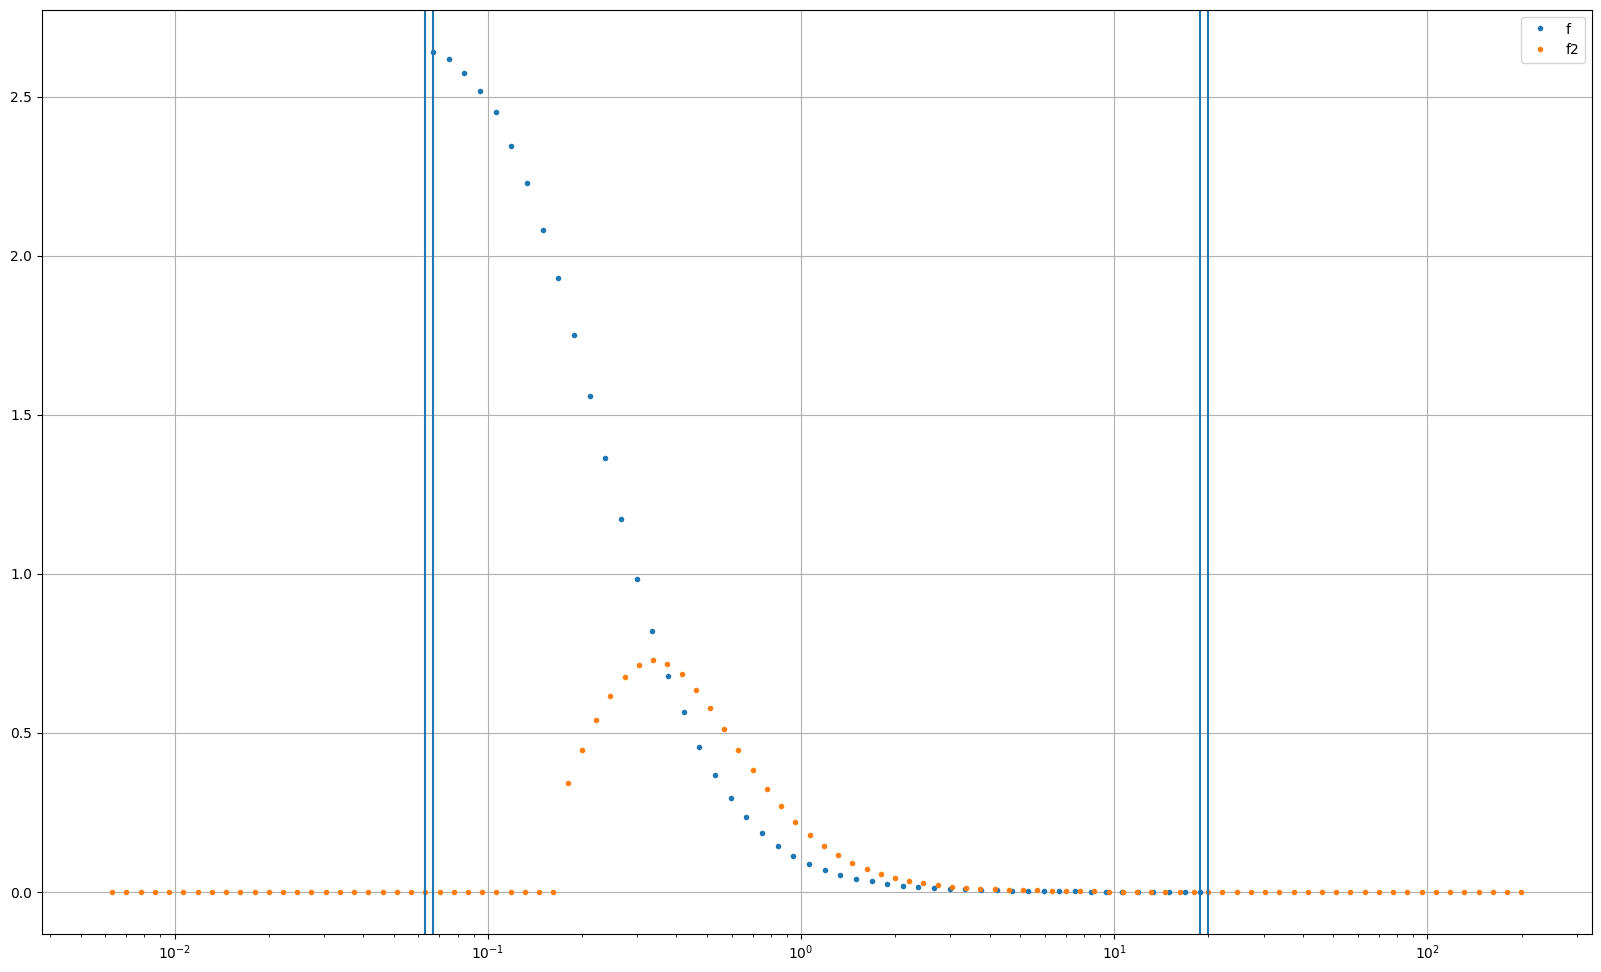

In [40]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(data.bin_centers, data.bin_values_f,'.', label='f')
ax.plot(xvalues, yvalues, '.', label='f2')
ax.axvline(x=data.bin_edges[0])
ax.axvline(x=data.bin_edges[-1])
ax.axvline(x=data.bin_centers[0])
ax.axvline(x=data.bin_centers[-1])
ax.set_xscale('log')
ax.grid();
ax.legend();

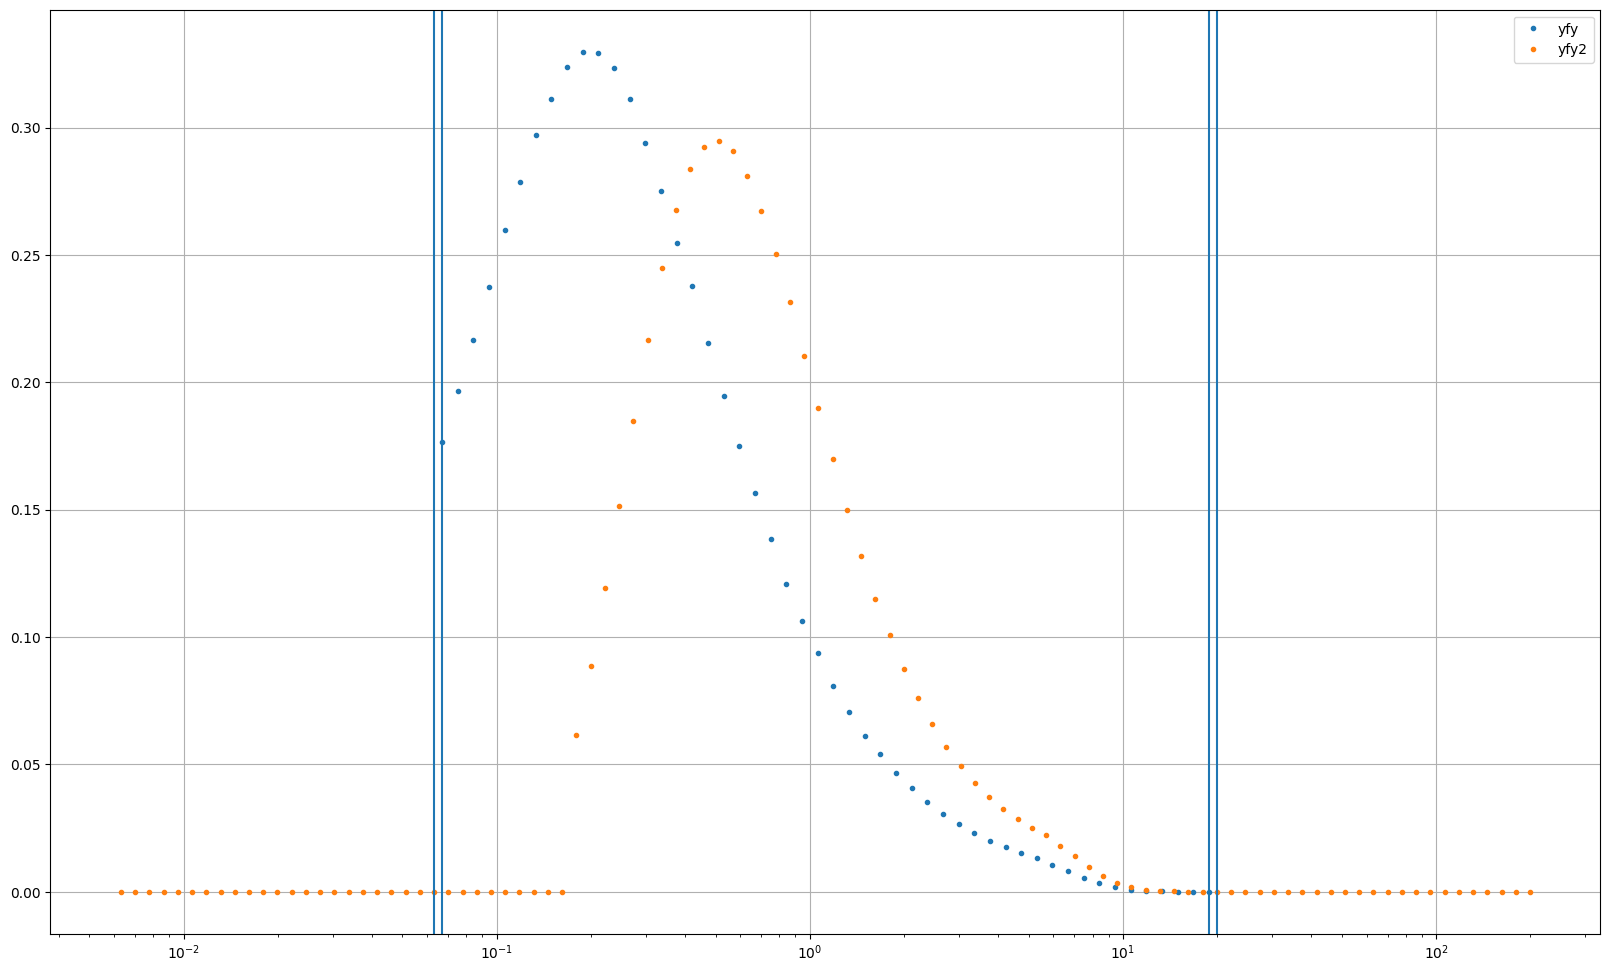

In [41]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(data.bin_centers, data.bin_values_f * data.bin_centers,'.', label='yfy')
ax.plot(xvalues, yvalues * xvalues, '.', label='yfy2')
ax.axvline(x=data.bin_edges[0])
ax.axvline(x=data.bin_edges[-1])
ax.axvline(x=data.bin_centers[0])
ax.axvline(x=data.bin_centers[-1])
ax.set_xscale('log')
ax.grid();
ax.legend();

# f2 calculation

In [42]:
xvalues = data.bin_centers[0] * data.bin_centers_ratio ** np.arange(start=0, stop=data.size+7)
yvalues = np.array([f2(y=y, data=data) for y in tqdm(xvalues)])

  0%|          | 0/57 [00:00<?, ?it/s]

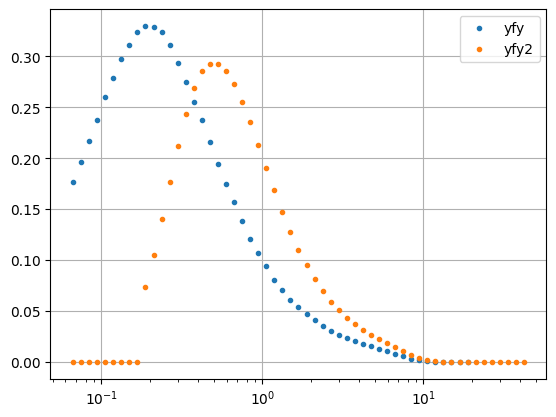

In [43]:
fig, ax = plt.subplots()
ax.plot(data.bin_centers, data.bin_values_f * data.bin_centers,'.', label='yfy')
ax.plot(xvalues, yvalues * xvalues, '.', label='yfy2')
ax.set_xscale('log')
ax.grid();
ax.legend();

In [44]:
df = pd.DataFrame(data={'y' : xvalues, 'yfy2' : yvalues})
df.head()

,y,yfy2
0,0.066830,0.0
1,0.074985,0.0
2,0.084134,0.0
3,0.094400,0.0
4,0.105919,0.0


In [45]:
df.to_excel('yfy2.xlsx', index=False)

# 1 um site, 25keV X-rays data

## Data

In [64]:
df = pd.read_csv('data.csv',
                 names=["y", "ydy"])
df.clip(lower=0.0, inplace=True)
df

,y,ydy
0,0.147235,0.003766
1,0.169098,0.003503
2,0.188893,0.004384
3,0.226118,0.006225
4,0.259668,0.008145
5,0.282130,0.010170
6,0.315126,0.013233
7,0.361754,0.022789
8,0.398406,0.031334
9,0.457333,0.041981


<Axes: xlabel='y', ylabel='ydy'>

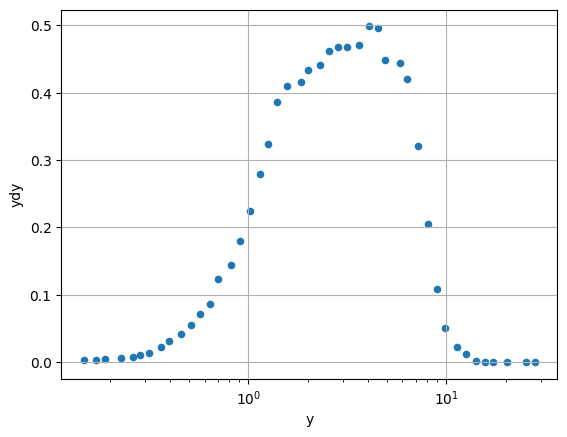

In [65]:
df.plot.scatter("y", "ydy", logx=True, grid=True)

In [66]:
df.y.min(), df.y.max()

(0.1472354900295554, 27.967881643052834)

In [67]:
xbins = np.geomspace(df.y.min(), df.y.max(), 50)
xbins

array([ 0.14723549,  0.16387606,  0.18239734,  0.20301191,  0.22595633,
        0.25149393,  0.2799178 ,  0.31155413,  0.34676601,  0.38595753,
        0.42957848,  0.47812948,  0.53216771,  0.59231335,  0.65925666,
        0.7337659 ,  0.81669619,  0.90899926,  1.01173443,  1.12608074,
        1.25335049,  1.39500426,  1.55266776,  1.72815041,  1.92346611,
        2.14085641,  2.38281619,  2.65212227,  2.95186536,  3.28548543,
        3.65681127,  4.07010439,  4.53010794,  5.04210112,  5.61195982,
        6.24622399,  6.95217275,  7.73790791,  8.61244691,  9.5858264 ,
       10.66921731, 11.87505315, 13.21717266, 14.71097864, 16.37361469,
       18.22416201, 20.28385835, 22.57634174, 25.12792179, 27.96788164])

In [68]:
import scipy
yvalues = scipy.interpolate.interp1d(df.y, df.ydy, kind='cubic')(xbins).clip(0)
yvalues

array([3.76567818e-03, 3.39746270e-03, 4.04885013e-03, 5.10601685e-03,
       6.21776261e-03, 7.55403051e-03, 9.97562870e-03, 1.27846555e-02,
       1.92068262e-02, 2.86262428e-02, 3.68787634e-02, 4.69360569e-02,
       6.20196580e-02, 7.49668804e-02, 9.95565045e-02, 1.33912200e-01,
       1.45071344e-01, 1.79676155e-01, 2.24639930e-01, 2.72296088e-01,
       3.21946256e-01, 3.83797727e-01, 4.09100887e-01, 4.10750119e-01,
       4.24781053e-01, 4.39725479e-01, 4.46317570e-01, 4.64775890e-01,
       4.67939223e-01, 4.67368892e-01, 4.72534217e-01, 4.99547698e-01,
       4.94933425e-01, 4.40252441e-01, 4.42019232e-01, 4.25923088e-01,
       3.51953097e-01, 2.48714883e-01, 1.41963435e-01, 6.47502458e-02,
       3.08694969e-02, 1.77563963e-02, 6.36293137e-03, 6.71389894e-04,
       2.43986531e-04, 0.00000000e+00, 0.00000000e+00, 3.55011111e-04,
       5.59584381e-04, 0.00000000e+00])

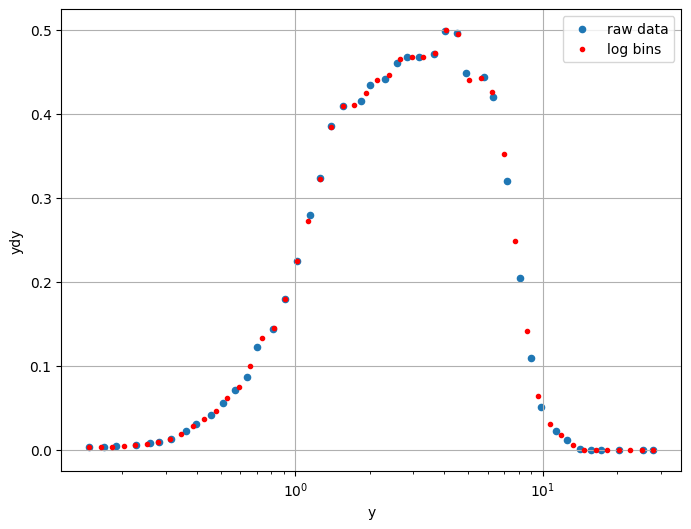

In [69]:
fig, ax = plt.subplots(figsize=(8, 6))
df.plot.scatter("y", "ydy", logx=True, grid=True, ax=ax, label="raw data")
ax.plot(xbins, yvalues, ".", label="log bins", color="red")
ax.legend();

In [70]:
data = Spectrum()
data.bin_centers = xbins
data.bin_values_ydy = yvalues
data.bin_values_yfy = data.bin_values_ydy * 0.3617 / data.bin_centers

## Inspections

Text(0, 0.5, 'ydy')

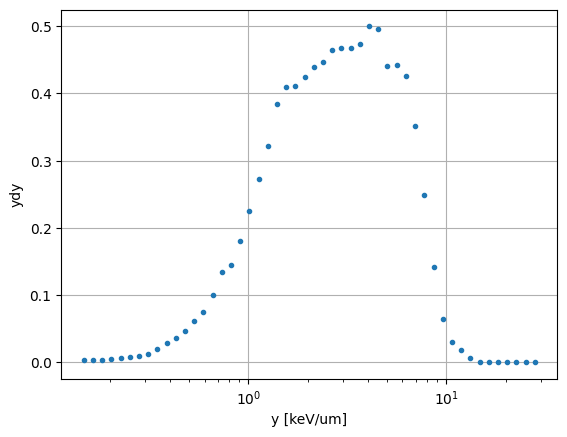

In [71]:
plt.plot(data.bin_centers, data.bin_values_ydy, '.')
plt.xscale('log')
plt.grid()
plt.xlabel('y [keV/um]')
plt.ylabel('ydy')

Text(0, 0.5, 'yfy')

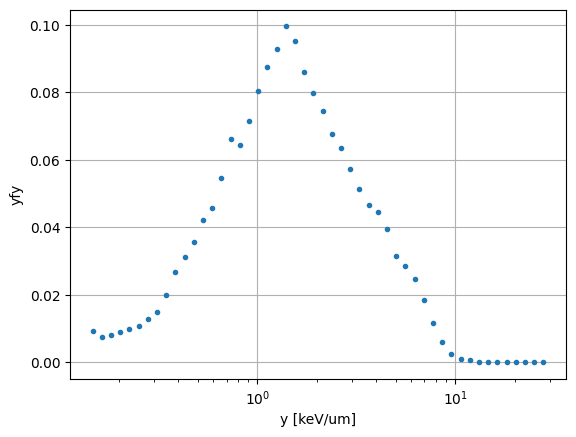

In [72]:
plt.plot(data.bin_centers, data.bin_values_yfy, '.')
plt.xscale('log')
plt.grid()
plt.xlabel('y [keV/um]')
plt.ylabel('yfy')

In [73]:
data.bin_centers_ratio

1.1130200847482192

In [74]:
data.lowest_bin_left_edge

0.1395600143463661

In [75]:
f_norm(data=data)

0.1854650909774389

## f2 calculation

In [76]:
xvalues = data.bin_centers[0] * data.bin_centers_ratio ** np.arange(start=-2, stop=data.size+6)
yvalues = np.array([f2(y=y, data=data) for y in tqdm(xvalues)])

  0%|          | 0/58 [00:00<?, ?it/s]

In [77]:
xvalues.max()

53.17133705284052

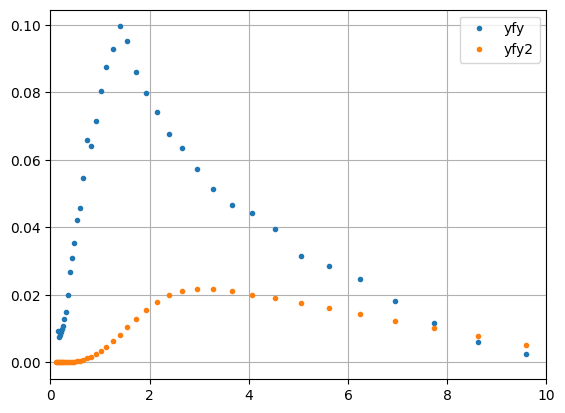

In [83]:
fig, ax = plt.subplots()
ax.plot(data.bin_centers, data.bin_values_f * data.bin_centers,'.', label='yfy')
ax.plot(xvalues, yvalues * xvalues, '.', label='yfy2')
#ax.set_xscale('log')
ax.set_xlim(0,10)
ax.grid();
ax.legend();

In [ ]:
# LG sprawdzic normalizacje
# PO czy widmo yfy jest trojkatne dla 25 keV 
# 10 mGy i 50 mGy ?
# zaczac od enegii ~12 keV
# PO jaka jest energia Xow
# dy = y * fy / yF
# ICRU36